In [ ]:
import numpy as np 
import pylab as plt

import torch
import torch.nn as nn
import lightning as L
from pathlib import Path
from dal_toolbox.models.deterministic import wide_resnet
from dal_toolbox.datasets import CIFAR10Plain
from dal_toolbox.models import deterministic
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox import metrics
from dal_toolbox.active_learning.strategies import RandomSampling, EntropySampling, Badge
from dal_toolbox.utils import seed_everything

In [ ]:
%%bash
# Mount path to trained SSL models
fusermount -uz /mnt/work/dhuseljic
sshfs cluster.ies:/mnt/work/dhuseljic /mnt/work/dhuseljic

In [23]:
simclr_checkpoint_path = '/mnt/work/dhuseljic/simclr_models/wide_resnet_28_10_CIFAR10_0.937.pth'
# simclr_checkpoint_path = '/mnt/work/dhuseljic/simclr_models/wide_resnet_28_10_CIFAR100_0.682.pth'
# simclr_checkpoint_path = '/mnt/work/dhuseljic/simclr_models/wide_resnet_28_10_SVHN_0.905.pth'
simclr_checkpoint = torch.load(simclr_checkpoint_path, map_location='cpu')

train_feature_ds = simclr_checkpoint['trainset']
test_feature_ds = simclr_checkpoint['testset']

np.random.seed(42)
X_train = train_feature_ds.features
y_train = train_feature_ds.labels
X_test = test_feature_ds.features
y_test = test_feature_ds.labels

# import torch
# from dal_toolbox.datasets.utils import FeatureDatasetWrapper
# dinov2_vits14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
# train_feature_ds  = FeatureDatasetWrapper("PATH")

In [24]:
from dal_toolbox.datasets import CIFAR10Plain
from dal_toolbox.models.deterministic import wide_resnet

cifar10 = CIFAR10Plain('/datasets')
#  img, lbl= cifar10.train_dataset[1]

model = wide_resnet.wide_resnet_28_10(10)
model.linear = nn.Identity()
model.load_state_dict(simclr_checkpoint['model'], )

dataloader = torch.utils.data.DataLoader(cifar10.train_dataset, batch_size=128, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
model.cuda()
train_features = [model(batch[0].cuda()) for batch in dataloader]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.65 GiB of which 12.75 MiB is free. Process 1207346 has 466.00 MiB memory in use. Including non-PyTorch memory, this process has 23.17 GiB memory in use. Of the allocated memory 22.61 GiB is allocated by PyTorch, and 110.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

<All keys matched successfully>

## Initial Cycle

In [ ]:
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

num_init_samples = 50
num_reps = 10
num_neighbors = 10

print('Clustering..')
y_cluster = KMeans(n_clusters=num_init_samples).fit_predict(X_train) # aux clustering for diversity
print('Training..')
aux_model = LogisticRegression(multi_class='multinomial').fit(X_train, y_train) # aux model for difficulty
# print('Distance Computation..')
# aux_dist, _ = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train).kneighbors(X_train) # aux dist for density 

all_scores = []
for i_rep in tqdm(range(num_reps)):
    np.random.seed(i_rep)

    scores = {}

    # Random
    indices = np.random.permutation(len(X_train))[:num_init_samples]
    model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    scores['random'] = model.score(X_test, y_test)

    # Diverse 
    indices = [np.random.choice(np.where(y_cluster == cluster)[0]) for cluster in np.unique(y_cluster)]
    model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    scores['diversity'] = model.score(X_test, y_test)

    # Difficulty -> always bad because model can not learn with difficult samples
    # probas = aux_model.predict_proba(X_train)
    # entropies = - np.sum(probas * np.log(probas+1e-19), axis=-1)
    # indices = entropies.argsort()[-num_init_samples:]
    # model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    # scores['difficulty'] = model.score(X_test, y_test)

    # Density -> only focuses on one class, hence we can not train a model
    # inverse_density = aux_dist.sum(axis=-1)
    # indices = inverse_density.argsort()[:num_init_samples]
    # model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    # scores['density'] = model.score(X_test, y_test)

    # Diversity + Density
    indices = []
    for cluster in np.unique(y_cluster):
        indices_cluster = np.where(y_cluster == cluster)[0]
        nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[indices_cluster])
        dist, _ = nn.kneighbors(X_train[indices_cluster])
        indices.append(indices_cluster[dist.sum(-1).argmin()])
    model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    scores['diversity + density'] = model.score(X_test, y_test)

    # Diversity + Difficulty
    indices = []
    for cluster in np.unique(y_cluster):
        indices_cluster = np.where(y_cluster == cluster)[0]
        probas = aux_model.predict_proba(X_train[indices_cluster])
        entropies = - np.sum(probas * np.log(probas+1e-19), axis=-1)
        indices.append(indices_cluster[entropies.argsort()[-1]])
    model = LogisticRegression(multi_class='multinomial').fit(X_train[indices], y_train[indices])
    scores['diversity + difficulty'] = model.score(X_test, y_test)

    all_scores.append(scores)

Clustering..


KeyboardInterrupt: 

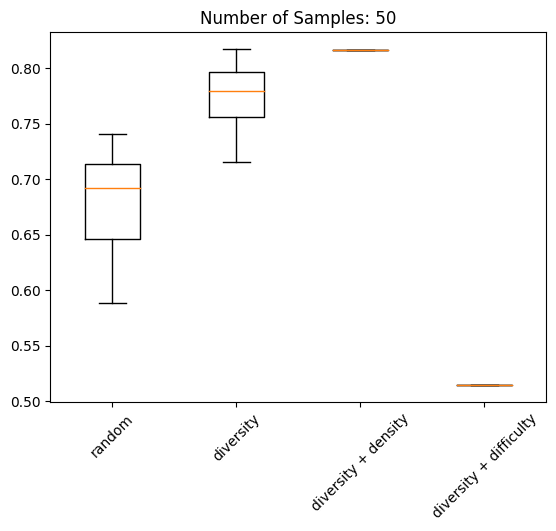

In [9]:
results = {key: np.mean([d[key] for d in all_scores]) for key in all_scores[0]}
results_std = {key: np.std([d[key] for d in all_scores]) for key in all_scores[0]}

# plt.bar(range(len(results)), results.values(), tick_label=list(results.keys()), yerr=list(results_std.values()))
plt.title('Number of Samples: {}'.format(num_init_samples))
plt.boxplot([[d[key] for d in all_scores] for key in all_scores[0]], labels=list(results.keys()))
plt.xticks(rotation=45)
plt.show()


### TSNE Visualization

In [8]:
from sklearn.manifold import TSNE
np.random.seed(0)
tsne = TSNE()
X_tsne = tsne.fit_transform(X_train)

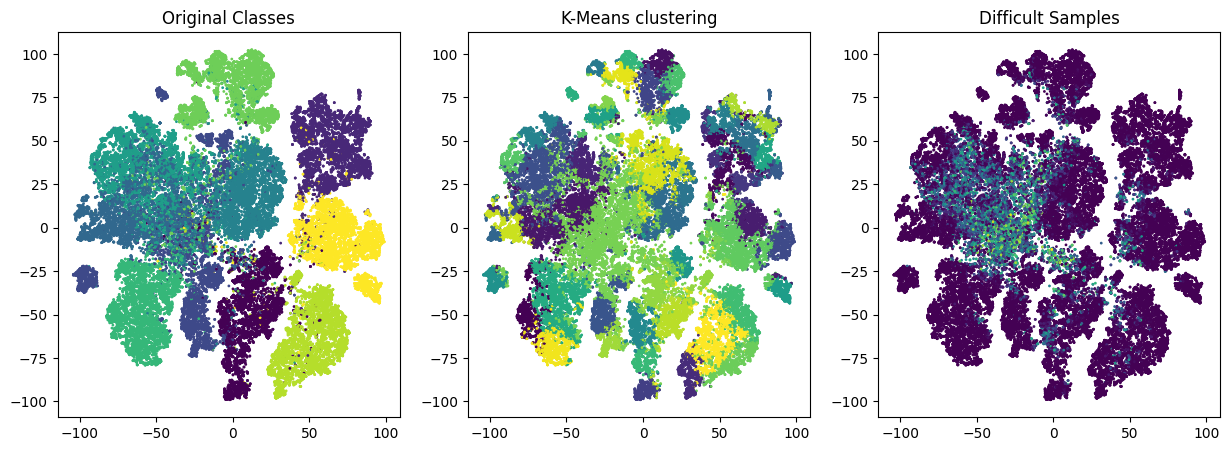

In [88]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegression

num_samples = 50
num_neighbors = 100

np.random.seed(1)
kmeans = KMeans(num_samples).fit(X_train)
aux_model = LogisticRegression(multi_class='multinomial').fit(X_train, y_train) # aux model for difficulty

cluster_train = kmeans.predict(X_train)
probas_train = aux_model.predict_proba(X_train)
difficulty_train = 1-np.max(probas_train, axis=-1)
# difficulty_train = - np.sum(probas_train * np.log(probas_train), axis=-1)

inverse_density_train = np.zeros(len(X_train))
for cluster in np.unique(cluster_train):
    cluster_indices = np.where(cluster_train == cluster)[0]
    nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[cluster_indices])
    dist, _ = nn.kneighbors(X_train[cluster_indices])
    inverse_density_cluster = dist.sum(-1)
    inverse_density_train[cluster_indices] = inverse_density_cluster



plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Original Classes')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, s=1)
plt.subplot(132)
plt.title('K-Means clustering')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_train, s=1)
plt.subplot(133)
plt.title('Difficult Samples')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=difficulty_train, s=1)

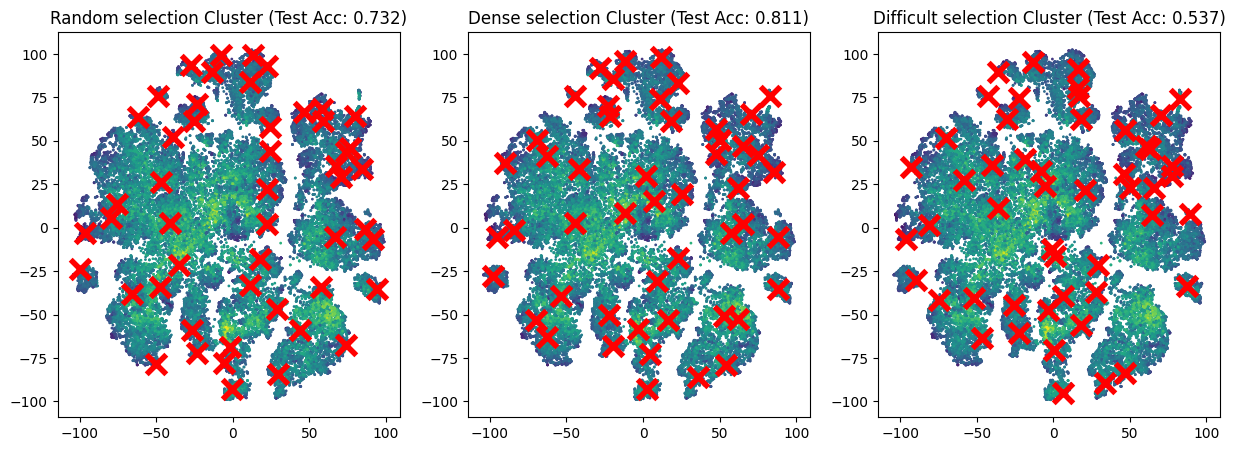

In [89]:
plt.figure(figsize=(15, 5))
# buy_indices = np.argsort(inverse_density_train)[:10]

buy_indices = [np.random.choice(np.where(cluster_train == cluster)[0]) for cluster in np.unique(cluster_train)]
model = LogisticRegression()
model.fit(X_train[buy_indices], y_train[buy_indices])
plt.subplot(131)
plt.title(f'Random selection Cluster (Test Acc: {model.score(X_test, y_test):.3f})', )
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=1/inverse_density_train, s=1)
plt.scatter(X_tsne[buy_indices , 0], X_tsne[buy_indices , 1], s=200, marker='x', c='r', linewidths=4)

buy_indices = []
for cluster in np.unique(cluster_train):
    cluster_indices = np.where(cluster_train == cluster)[0]

    idx = np.argmin(inverse_density_train[cluster_indices])
    buy_indices.append(cluster_indices[idx])
model = LogisticRegression()
model.fit(X_train[buy_indices], y_train[buy_indices])
plt.subplot(132)
plt.title(f'Dense selection Cluster (Test Acc: {model.score(X_test, y_test):.3f})', )
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=1/inverse_density_train, s=1)
plt.scatter(X_tsne[buy_indices , 0], X_tsne[buy_indices , 1], s=200, marker='x', c='r', linewidths=4)

buy_indices = []
for cluster in np.unique(cluster_train):
    cluster_indices = np.where(cluster_train == cluster)[0]
    idx = np.argsort(difficulty_train[cluster_indices])[-1]
    buy_indices.append(cluster_indices[idx])
model = LogisticRegression()
model.fit(X_train[buy_indices], y_train[buy_indices])
plt.subplot(133)
plt.title(f'Difficult selection Cluster (Test Acc: {model.score(X_test, y_test):.3f})', )
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=1/inverse_density_train, s=1)
plt.scatter(X_tsne[buy_indices , 0], X_tsne[buy_indices , 1], s=200, marker='x', c='r', linewidths=4)

plt.show()

In [35]:
nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[y_train == 0])
dist, _ = nn.kneighbors(X_train)

In [46]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(100, covariance_type='diag')
gmm.fit(X_train)

GaussianMixture(covariance_type='diag', n_components=100)

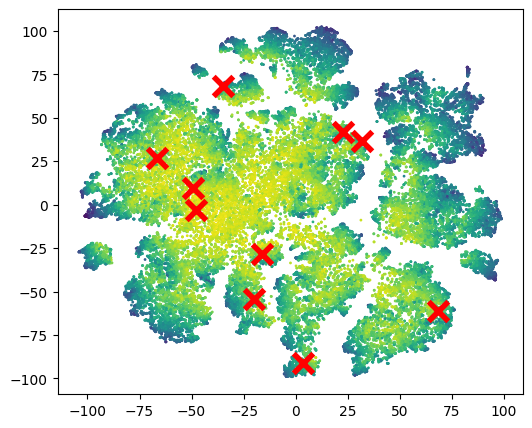

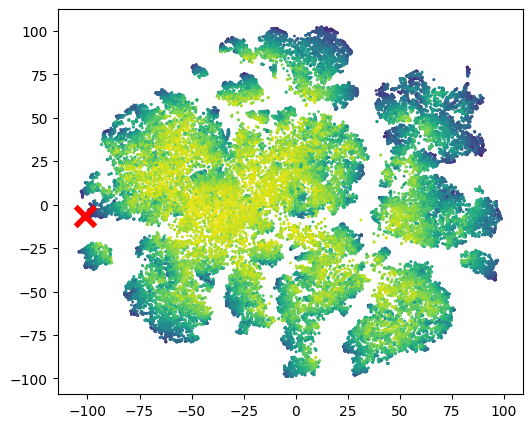

NameError: name 'nn_un' is not defined

In [90]:
# 1. Init random; buy with Strategy
# 2. Init with strategy; buy with Strategy
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from scipy.special import loggamma

num_samples_random_init = 10
num_neighbors = 10
num_samples_strategy = 1

learning_curves = {}

## Random init + random buy
np.random.seed(0)
unlabeled_indices = np.arange(len(X_train))
labeled_indices = np.array([], dtype=int)

# First buy
indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
labeled_indices = np.union1d(labeled_indices, indices)

nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[labeled_indices])
plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=1/nn.kneighbors(X_train)[0].sum(-1),  s=1)
plt.scatter(X_tsne[indices, 0], X_tsne[indices , 1], s=200, marker='x', c='r', linewidths=4)
plt.show()

for i in range(10):
    dist, _ = nn.kneighbors(X_train[unlabeled_indices])
    density = 1/np.sum(dist, axis=-1)
    indices = [unlabeled_indices[density.argmin()]]
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)

    nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[labeled_indices])

    plt.figure(figsize=(6, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = 1/nn.kneighbors(X_train)[0].sum(-1),  s=1)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices , 1], s=200, marker='x', c='r', linewidths=4)
    plt.show()

    nn_labeled = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[labeled_indices])
    nn_unlabeled = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[unlabeled_indices])

    log_p = (np.log(num_neighbors) - np.log(len(labeled_indices)) - 
                320 * np.log(np.pi) - loggamma(320 + 1) -
                np.log(nn_un.kneighbors(X_train)[0][:, -1]))
    # q = 1/nn_unlabeled.kneighbors(X_train)[0].sum(-1)
    # q /= q.sum()
    # # dist = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2)) / np.sqrt(2)
    # kl = np.sum(p * (np.log(p) - np.log(q)), axis=-1)
    # print(kl)



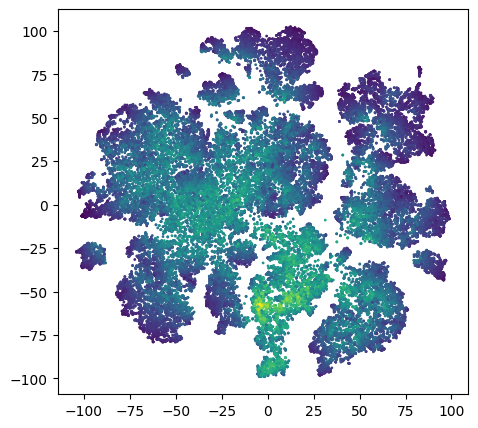

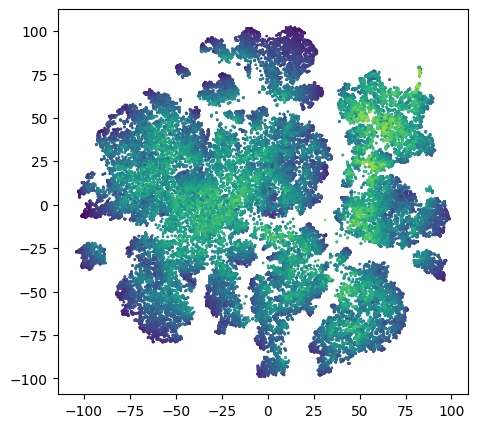

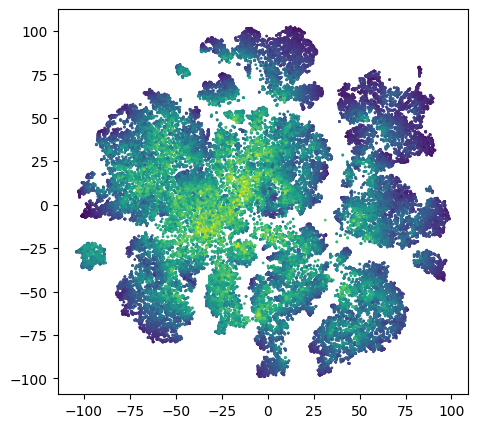

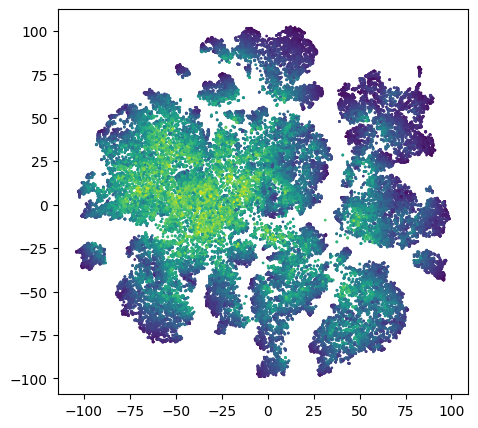

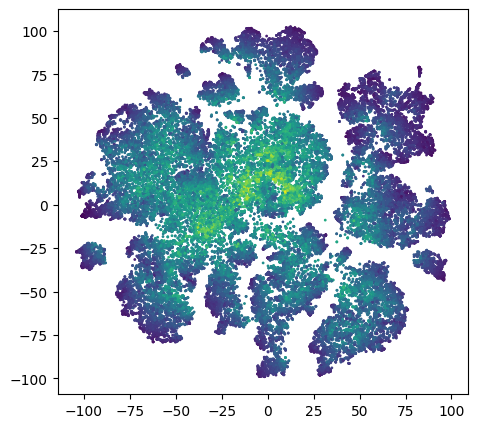

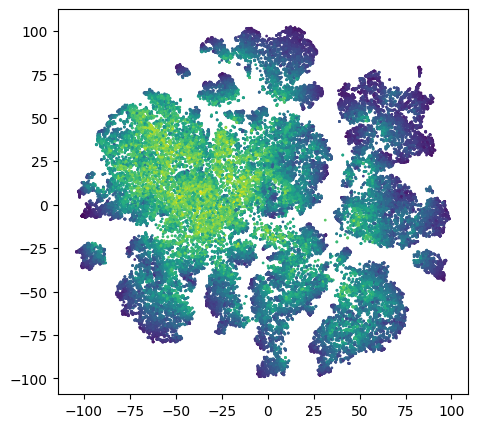

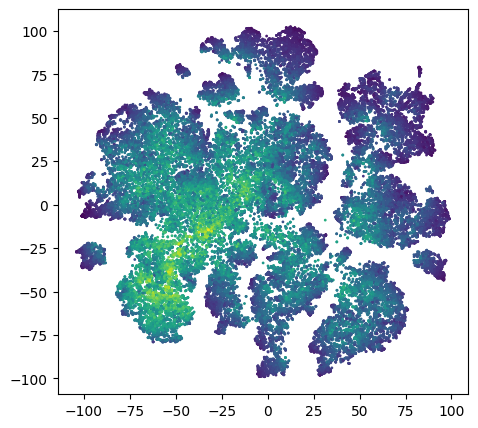

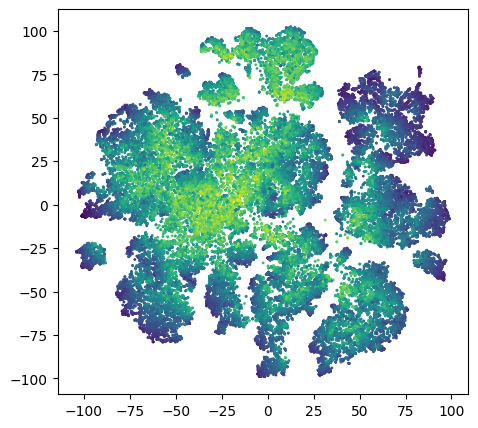

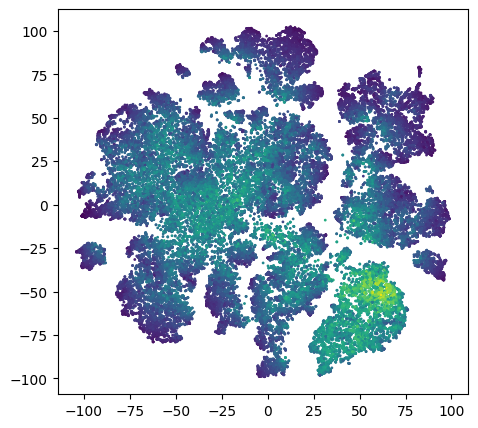

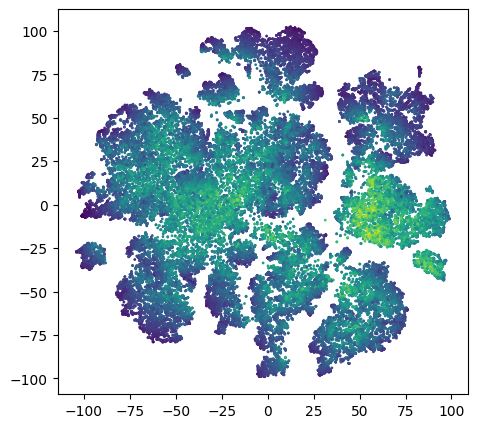

In [37]:
for i in range(10):
    nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[y_train == i])
    dist, _ = nn.kneighbors(X_train)

    density = 1/dist.sum(-1)

    plt.figure(figsize=(6*3, 5))
    plt.subplot(131)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=density, s=1)
    plt.show()
    # plt.scatter(X_tsne[:100, 0], X_tsne[:100, 1], c=density[:100], s=1)

In [11]:
from sklearn.cluster import KMeans, MiniBatchKMeans
y_kmeans = KMeans(n_clusters=10).fit_predict(X_train)
y_kmeans_mb = MiniBatchKMeans(n_clusters=10).fit_predict(X_train)

<Axes: >

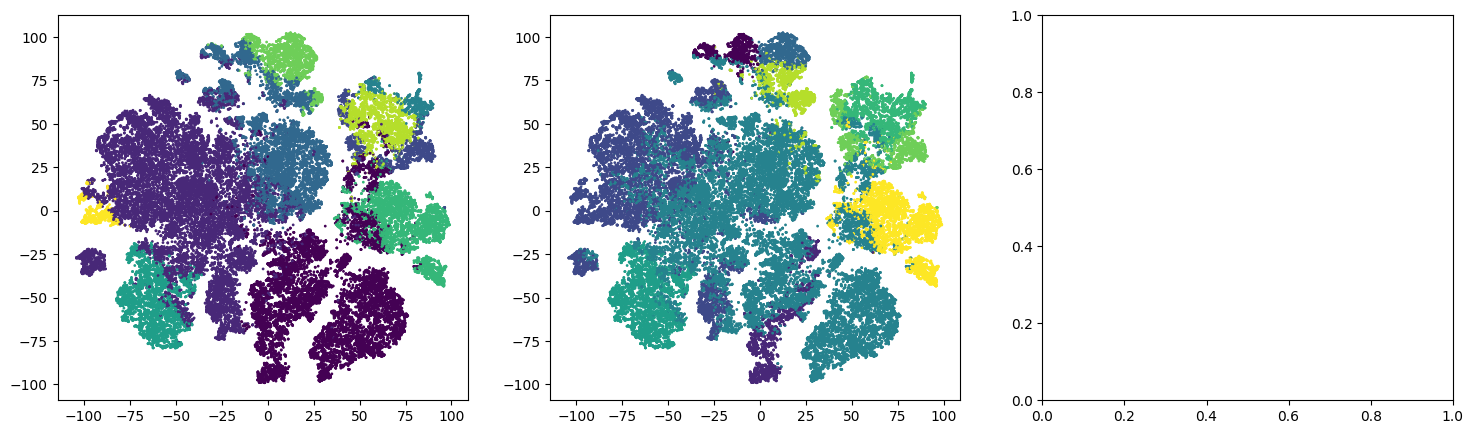

In [12]:
plt.figure(figsize=(6*3, 5))
plt.subplot(131)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_kmeans, s=1)
plt.subplot(132)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_kmeans_mb, s=1)
plt.subplot(133)

## Second Cycle

In [18]:
# 1. Init random; buy with Strategy
# 2. Init with strategy; buy with Strategy
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

aux_model = LogisticRegression(multi_class='multinomial').fit(X_train, y_train) # aux model for difficulty

num_reps = 20
num_samples_random_init = 1000
num_samples_strategy = 10

all_learning_curves = []
for i_rep in tqdm(range(num_reps)):
    learning_curves = {}

    ## Random init + random buy
    np.random.seed(i_rep)
    learning_curve = []
    unlabeled_indices = np.arange(len(X_train))
    labeled_indices = np.array([], dtype=int)

    # First buy
    indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    # Second buy
    indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    learning_curves['random + random'] = learning_curve

    ## Random init + diverse buy
    np.random.seed(i_rep)
    learning_curve = []
    unlabeled_indices = np.arange(len(X_train))
    labeled_indices = np.array([], dtype=int)

    # First buy
    indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    # Second buy
    y_cluster = MiniBatchKMeans(n_clusters=num_samples_strategy).fit_predict(X_train[unlabeled_indices]) # aux clustering for diversity
    indices = [np.random.choice(np.where(y_cluster == cluster)[0]) for cluster in np.unique(y_cluster)]
    indices = [unlabeled_indices[idx] for idx in indices]
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    learning_curves['random + div/ran'] = learning_curve

    ## Random init + diverse and dense buy
    np.random.seed(i_rep)
    learning_curve = []
    unlabeled_indices = np.arange(len(X_train))
    labeled_indices = np.array([], dtype=int)

    # First buy
    indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    # Second buy
    y_cluster = MiniBatchKMeans(n_clusters=num_samples_strategy).fit_predict(X_train[unlabeled_indices]) # aux clustering for diversity
    indices = []
    for cluster in np.unique(y_cluster):
        indices_cluster = np.where(y_cluster == cluster)[0]
        nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[unlabeled_indices][indices_cluster])
        dist, _ = nn.kneighbors(X_train[unlabeled_indices][indices_cluster])
        indices.append(indices_cluster[dist.sum(-1).argmin()])
    indices = [unlabeled_indices[idx] for idx in indices]
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    learning_curves['random + div/den'] = learning_curve

    ## Random init + diverse and difficulty
    np.random.seed(i_rep)
    learning_curve = []
    unlabeled_indices = np.arange(len(X_train))
    labeled_indices = np.array([], dtype=int)

    # First buy
    indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))

    # Second buy
    aux_model
    y_cluster = MiniBatchKMeans(n_clusters=num_samples_strategy).fit_predict(X_train[unlabeled_indices]) # aux clustering for diversity
    indices = []
    for cluster in np.unique(y_cluster):
        indices_cluster = np.where(y_cluster == cluster)[0]
        # aux_model = "perfect" uncertainty
        # model = "temp" uncertainty
        probas = model.predict_proba(X_train[unlabeled_indices][indices_cluster]) 
        entropies = - np.sum(probas * np.log(probas+1e-19), axis=-1)
        indices.append(indices_cluster[entropies.argsort()[-1]])
    indices = [unlabeled_indices[idx] for idx in indices]
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)
    model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
    learning_curve.append(model.score(X_test, y_test))
    learning_curves['random + div/dif'] = learning_curve
    
    ## Random init + diverse and difficulty
    # np.random.seed(i_rep)
    # learning_curve = []
    # unlabeled_indices = np.arange(len(X_train))
    # labeled_indices = np.array([], dtype=int)

    # First buy
    # nn = NearestNeighbors(n_neighbors=5).fit(X_train)
    # dist, indices = nn.kneighbors(X_train)

    all_learning_curves.append(learning_curves)

100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


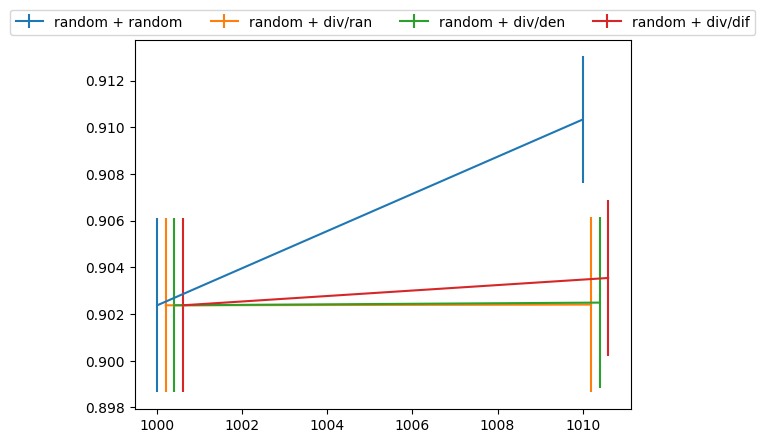

In [19]:
for i_strat, strat_name in enumerate(all_learning_curves[0].keys()):
    learning_curves_strat = [learning_curve[strat_name] for learning_curve in all_learning_curves]
    acc_mean = np.mean(learning_curves_strat, axis=0)
    acc_std = np.std(learning_curves_strat, axis=0)

    # plt.plot(acc_mean, label=strat_name)
    num_samples = np.array([num_samples_random_init, num_samples_random_init + num_samples_strategy]) + i_strat*.2
    plt.errorbar(num_samples, acc_mean, yerr=acc_std, label=strat_name)

plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

In [45]:
gmm.weights_
gmm.means_[0]

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'features',
 'labels']

In [55]:
y_train[buy_indicesg]

tensor([0, 4, 0, 0, 2, 0, 4, 4, 0, 4])

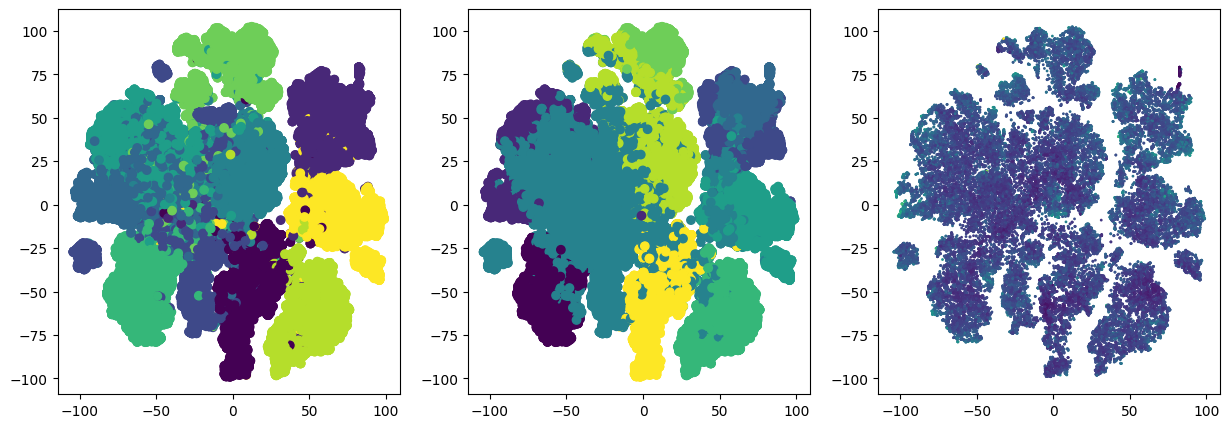

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train)
plt.subplot(132)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_train)
plt.subplot(133)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=inverse_density_train, s=1)
plt.show()

## AL with SSL

In [9]:
np.random.seed(42)
X_train = train_feature_ds.features
y_train = train_feature_ds.labels
X_test = test_feature_ds.features
y_test = test_feature_ds.labels

Seed set to 1
Seed set to 2
Seed set to 3
Seed set to 4
Seed set to 5
Seed set to 6
Seed set to 7
Seed set to 8
Seed set to 9
Seed set to 10


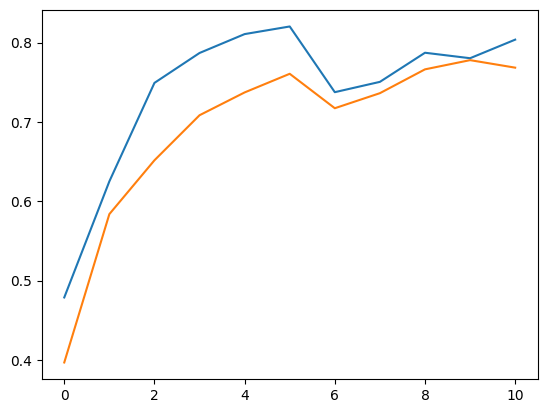

In [64]:
import torch
import logging
import torch.nn as nn
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import RandomSampling
from dal_toolbox.utils import seed_everything
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)


num_init = 10
num_acq = 10
acq_size = 10
num_reps = 10

curves = []
for i_rep in range(num_reps):
    seed_everything(i_rep+1)

    al_datamodule = ActiveLearningDataModule(train_feature_ds, train_feature_ds)
    al_datamodule.random_init(n_samples=num_init)

    qs = RandomSampling()

    model = nn.Linear(640, 10)
    model = DeterministicModel(model, optimizer=torch.optim.LBFGS(model.parameters()))

    learning_curve = []
    for i_acq in range(0, num_acq+1):
        if i_acq != 0:
            indices = qs.query(al_datamodule=al_datamodule, acq_size=10)
            al_datamodule.update_annotations(indices)

        # Train
        model.reset_states()
        trainer = L.Trainer(max_epochs=50, enable_checkpointing=False, enable_model_summary=False, enable_progress_bar=False)
        trainer.fit(model, al_datamodule)

        # Eval
        with torch.no_grad():
            acc = (model(X_test).argmax(-1) == y_test).float().mean()
        learning_curve.append({'acc': acc})
    curves.append(learning_curve)

plt.plot([d['acc'] for d in learning_curve])
plt.plot(np.mean([[d['acc'] for d in lc] for lc in curves], axis=0))

(10, 11)

In [7]:
import torch

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from scipy.special import loggamma

num_init = 10


## Random init + random buy
np.random.seed(0)
unlabeled_indices = np.arange(len(X_train))
labeled_indices = np.array([], dtype=int)

# Init AL
indices = np.random.choice(unlabeled_indices, size=num_samples_random_init)
unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
labeled_indices = np.union1d(labeled_indices, indices)

for i in range(10):
    dist, _ = nn.kneighbors(X_train[unlabeled_indices])
    density = 1/np.sum(dist, axis=-1)
    indices = [unlabeled_indices[density.argmin()]]
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)

    nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[labeled_indices])
    nn_labeled = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[labeled_indices])
    nn_unlabeled = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[unlabeled_indices])

NameError: name 'X_tsne' is not defined

<Figure size 600x500 with 0 Axes>

## Single Instance AL

In [9]:
np.random.seed(42)
X_train = train_feature_ds.features
y_train = train_feature_ds.labels
X_test = test_feature_ds.features
y_test = test_feature_ds.labels

In [93]:
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from skactiveml.pool import cost_reduction

strat = 'pal'
num_reps = 10
num_cycles = 10
num_neighbors = 250

learning_curves = []
for i_rep in tqdm(range(num_reps)):
    np.random.seed(i_rep)
    unlabeled_indices = np.arange(len(X_train))
    labeled_indices = np.array([], dtype=int)

    indices = np.random.choice(unlabeled_indices, size=10)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
    labeled_indices = np.union1d(labeled_indices, indices)

    learning_curve = []
    for i_cycle in range(num_cycles+1):
        if i_cycle != 0:
            if strat == 'unc':
                log_probas = model.predict_log_proba(X_train[unlabeled_indices])
                idx = unlabeled_indices[log_probas.max(-1).argmin()]
            if strat == 'pal':
                unlabeled_indices_subset = np.random.choice(unlabeled_indices, size=1000)
                unl_lab_indices = np.concatenate((unlabeled_indices_subset, labeled_indices))
                nn = NearestNeighbors(n_neighbors=num_neighbors).fit(X_train[unl_lab_indices])
                dist, nn_indices = nn.kneighbors(X_train[unl_lab_indices])
                K = []
                for neighbor_indices in nn_indices:
                    k_vec = np.zeros(10)
                    # check if any neighbor has a label and count that label up
                    for idx1 in neighbor_indices:
                        idx1 = unl_lab_indices[idx1]
                        if idx1 in labeled_indices:
                            k_vec[y_train[idx1]] += 1
                    K.append(k_vec)
                K = np.array(K)
                gain = cost_reduction(K, m_max=1)
                idx = unlabeled_indices_subset[gain.argmax()]
            unlabeled_indices = np.setdiff1d(unlabeled_indices, idx)
            labeled_indices = np.union1d(labeled_indices, idx)

        model = LogisticRegression().fit(X_train[labeled_indices], y_train[labeled_indices])
        learning_curve.append(model.score(X_test, y_test))

    learning_curves.append(learning_curve)

100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


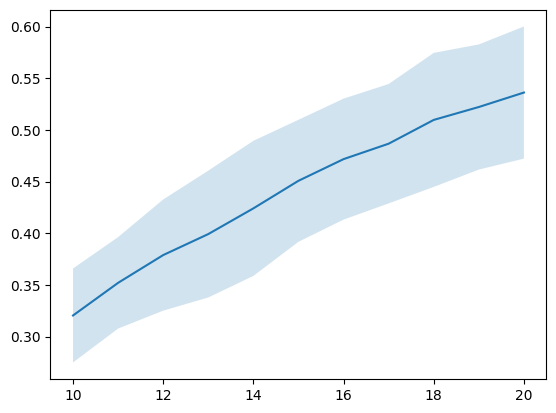

In [95]:
num_samples = np.cumsum([10] + [1 for _ in range(len(learning_curves[0])-1)])
lc_mean = np.mean(learning_curves, axis=0)
lc_std = np.std(learning_curves, axis=0)

plt.plot(num_samples, lc_mean)
plt.fill_between(num_samples, lc_mean-lc_std, lc_mean+lc_std, alpha=0.2)

## Nearest Neighbor PAL 

In [ ]:
np.random.seed(42)
X_train = train_feature_ds.features
y_train = train_feature_ds.labels
X_test = test_feature_ds.features
y_test = test_feature_ds.labels

In [62]:
unlabeled_indices = np.arange(len(X_train))
labeled_indices = np.array([], dtype=int)

indices = np.random.choice(unlabeled_indices, size=10)
unlabeled_indices = np.setdiff1d(unlabeled_indices, indices)
labeled_indices = np.union1d(labeled_indices, indices)

dist, nn_indices = nn.kneighbors(X_train)
K = []

for _ in unlabeled_indices:
    k_vec = np.zeros(10)
    for idx1 in nn_indices[idx]:
        if idx1 in labeled_indices:
            k_vec[y_train[idx1]] += 1
    K.append(k_vec)
K

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),


In [178]:
from skactiveml.pool import cost_reduction
gain = cost_reduction(K, m_max=1)6

In [194]:
K[gain.argsort()[-1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

tensor(9)

In [161]:
# indices.shape
y_train


(50000, 5)

In [ ]:
def estimate_performance(model, X_test):
    # Estimate performance
    # expected risk = E_p(x) E_p(y|x) [L(f(x), y)] = \sum_x \sum_y p(y|x) L(f(x), y)
    y_proba = model.predict_proba(X_test)
    n_classes = y_proba.shape[-1]

    # L = zero one loss
    perf = np.mean(np.sum(y_proba * (1-np.eye(10)[y_proba.argmax(axis=-1)]), axis=-1))

    # L = crossentropy
    # perf = np.mean(np.sum(y_proba * - np.log(y_proba), axis=-1))
    return  perf

In [123]:

n_classes = 10
y_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=-1)

proba = y_proba[0]
pred = y_pred[0]


1.6042803906980216

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

In [91]:
# y_proba
i_class = 0

0.5259354069184572

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
gmm = BayesianGaussianMixture(n_components=10).fit(X_train)

In [84]:
dist_mat = pairwise_distances(X_train)

In [25]:

y_cluster = KMeans(n_clusters=num_init_samples).fit_predict(X_train)


22343
27160
24782
18780
17949
26495
20076
49060
6463
32665


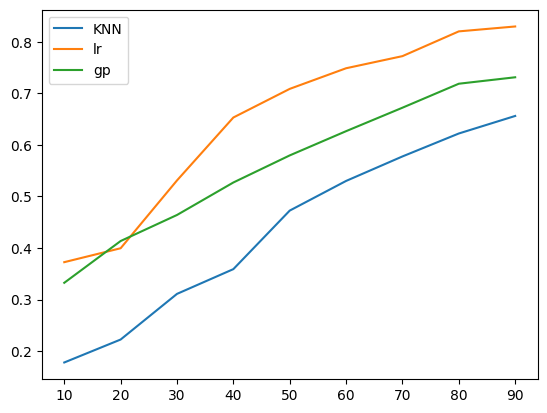

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier


num_samples_list = np.arange(10, 100, 10)

scores = []
for num_samples in num_samples_list:
    np.random.seed(1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    clf = KNeighborsClassifier()
    clf.fit(X_train[:num_samples], y_train[:num_samples])
    score_knn = clf.score(X_test, y_test)

    clf = LogisticRegression()
    clf.fit(X_train[:num_samples], y_train[:num_samples])
    score_lr = clf.score(X_test, y_test)

    clf = GaussianProcessClassifier()
    clf.fit(X_train[:num_samples], y_train[:num_samples])
    score_gp = clf.score(X_test, y_test)

    scores.append({'knn': score_knn, 'lr': score_lr, 'gp': score_gp})

plt.plot(num_samples_list, [d['knn'] for d in scores], label='KNN')
plt.plot(num_samples_list, [d['lr'] for d in scores], label='lr')
plt.plot(num_samples_list, [d['gp'] for d in scores], label='gp')
plt.legend()
plt.show()

In [55]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline



Pipeline(steps=[RBFSampler(random_state=0), LogisticRegression(random_state=1)])

In [ ]:
from sklearn.cluster import KMeans

In [41]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

from skactiveml.pool import UncertaintySampling, RandomSampling, ProbabilisticAL
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier
from skactiveml.classifier import ParzenWindowClassifier

np.random.seed(1)

# Generate data set.

clfs = {# 'gp': GaussianProcessClassifier(random_state=0), 
        'log_reg': LogisticRegression(random_state=0),
        # 'knn': KNeighborsClassifier(),
        'pwc': ParzenWindowClassifier(random_state=0, class_prior=10, metric_dict={'gamma': 'mean'}),
        # 'sngp': Pipeline([('rff', RBFSampler(random_state=0, gamma=.1, n_components=1024)), ('log_reg', LogisticRegression(random_state=1) )])
}

learning_curves = {}
for clf_name, clf in clfs.items(): 
    np.random.seed(0)
    X = train_feature_ds.features
    y_true = train_feature_ds.labels
    X_test = test_feature_ds.features
    y_test = test_feature_ds.labels
    # y = test_feature_ds.labels
    # X = (X - X.mean(0)) / X.std(0)
    # X, X_test, y_true, y_test = train_test_split(X, y, test_size=.2)

    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    y[:10] = y_true[:10]

    # Create classifier and query strategy.
    clf = SklearnClassifier(clf, classes=np.unique(y_true), random_state=0)
    qs = UncertaintySampling(method='entropy')
    # qs = RandomSampling()
    # qs = ProbabilisticAL(metric='rbf', metric_dict={'gamma': 'mean'})

    # Execute active learning cycle.
    learning_curve = []
    n_cycles = 20
    for c in tqdm(range(n_cycles)):
        if c != 0:
            query_idx = qs.query(X=X, y=y, clf=clf, fit_clf=False)
            # query_idx = qs.query(X=X, y=y)
            y[query_idx] = y_true[query_idx]
        clf.fit(X, y)

        learning_curve.append({'score': clf.score(X_test, y_test)})
    learning_curves[clf_name] = learning_curve

100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


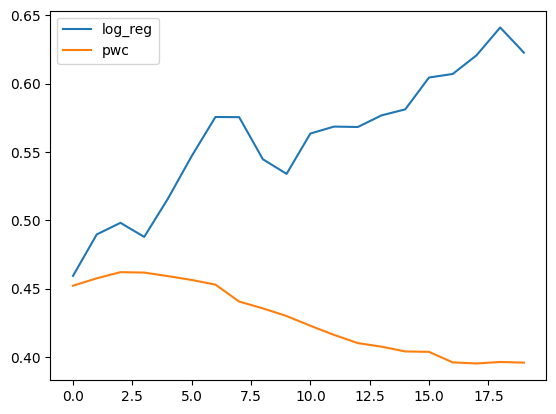

In [42]:
plt.plot([d['score'] for d in learning_curves['log_reg']], label='log_reg')
plt.plot([d['score'] for d in learning_curves['pwc']], label='pwc')
# plt.plot([d['score'] for d in learning_curves['knn']], label='knn')
# plt.plot([d['score'] for d in learning_curves['gp']], label='gp')
plt.legend()
plt.show()

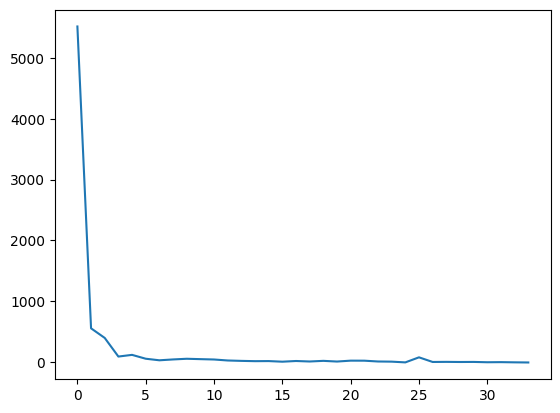

In [179]:
from sklearn.mixture import GaussianMixture
np.random.seed(1)
X, y_true = make_blobs([100, 200, 50])
X = (X - X.mean(axis=0)) / X.std(axis=0)

kl_divs = []

for num_samples in np.arange(10, len(X), 10):
    unlabeled_indices = np.arange(len(X))
    labeled_indices = np.random.choice(unlabeled_indices, num_samples)
    unlabeled_indices = np.setdiff1d(unlabeled_indices, labeled_indices)

    xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
    zz = np.c_[xx.ravel(), yy.ravel()]

    # plt.figure(figsize=(10, 5))
    # plt.subplot(121)
    gmm_unlabeled = GaussianMixture(3)
    gmm_unlabeled.fit(X[unlabeled_indices])
    density = gmm_unlabeled.score_samples(zz)
    # plt.contourf(xx, yy, density.reshape(xx.shape), alpha=.5, levels=10)
    # plt.scatter(X[:, 0], X[:, 1], c=y_true)

    # plt.subplot(122)
    gmm_labeled = GaussianMixture(3)
    gmm_labeled.fit(X[labeled_indices])
    density = gmm_labeled.score_samples(zz)
    # plt.contourf(xx, yy, density.reshape(xx.shape), alpha=.5, levels=10)
    # plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], c=y_true[unlabeled_indices], s=1)
    # plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c='k', s=200, linewidths=5, marker='x')
    # plt.show()

    p = gmm_unlabeled.score_samples(X)
    q = gmm_labeled.score_samples(X)
    # print('KL', np.sum(np.exp(p) * (p - q)))
    kl_divs.append(np.sum((p - q)))
plt.plot(kl_divs)

In [167]:

def finished_exploration(X, unlabeled_indices, labeled_indices):

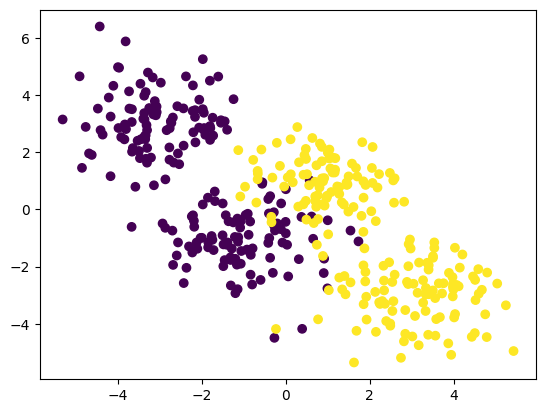

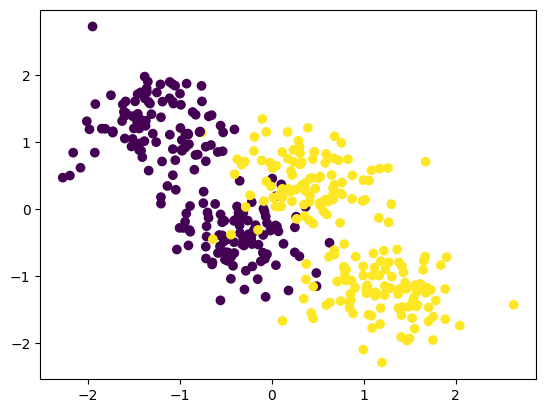

In [204]:
np.random.seed(1)
X = np.concatenate([
    np.random.normal(loc=-1, size=(100, 2)),
    np.random.normal(loc=1, size=(100, 2)),
    np.random.multivariate_normal(mean=[-3, 3], cov=np.eye(2), size=100),
    np.random.multivariate_normal(mean=[3, -3], cov=np.eye(2), size=100),
])
y = np.concatenate([
    np.zeros(100),
    np.ones(100),
    np.zeros(100),
    np.ones(100),
])
X = (X - X.mean(axis=0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

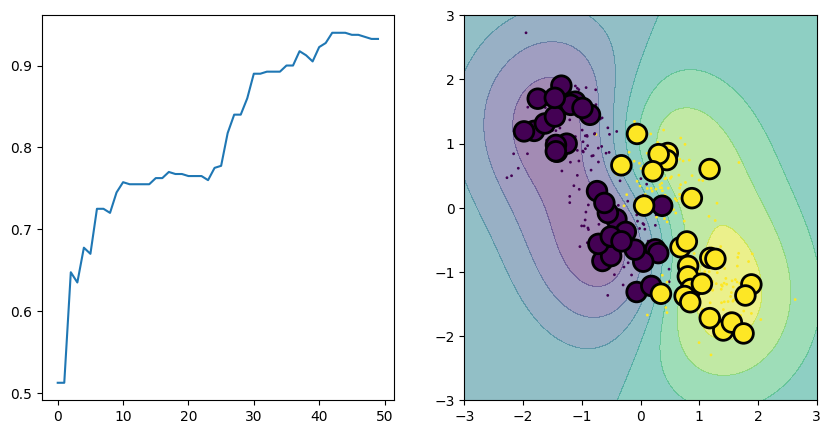

In [231]:
np.random.seed(42)
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs, make_moons
from skactiveml.pool import RandomSampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
zz = np.c_[xx.ravel(), yy.ravel()]
y_labeled = np.full(shape=y.shape, fill_value=MISSING_LABEL)

# Use the first 10 instances as initial training data.
y_labeled[:10] = y[:10]

# Create classifier and query strategy.
clf = SklearnClassifier(GaussianProcessClassifier(random_state=0), classes=[0, 1], random_state=0)
qs = RandomSampling()
qs_ = UncertaintySampling()

# Execute active learning cycle.
learning_curve = []
n_cycles = 50
kl_divs = []

qs_type ='explore'
for c in range(n_cycles):
    # Check exploration
    unlabeled_indices = np.isnan(y_labeled)
    gmm_unlabeled = GaussianMixture(4)
    gmm_unlabeled.fit(X[unlabeled_indices])

    labeled_indices = ~np.isnan(y_labeled)
    gmm_labeled = GaussianMixture(4)
    gmm_labeled.fit(X[labeled_indices])

    p = gmm_unlabeled.score_samples(X)
    q = gmm_labeled.score_samples(X)

    kl = np.sum(p - q)
    kl_divs.append(kl)

    if kl < 79.86175149035405:
        qs_type = 'exploit'

    if qs_type == 'explore':
        query_idx = qs.query(X=X, y=y_labeled)
    else:
        query_idx = qs_.query(X=X, y=y_labeled, clf=clf)

    y_labeled[query_idx] = y[query_idx]

    clf.fit(X, y_labeled)
    learning_curve.append(clf.score(X, y))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(learning_curve)

plt.subplot(122)
proba = clf.predict_proba(zz)[:, 1]
plt.contourf(xx, yy, proba.reshape(xx.shape), alpha=.5)

# plt.contourf(xx, yy, gmm_labeled.score_samples(zz).reshape(xx.shape), alpha=.5, levels=10)
plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
plt.scatter(X[:, 0], X[:, 1], c=y_labeled, s=200, linewidths=2, marker='o', edgecolors='black')
plt.show()

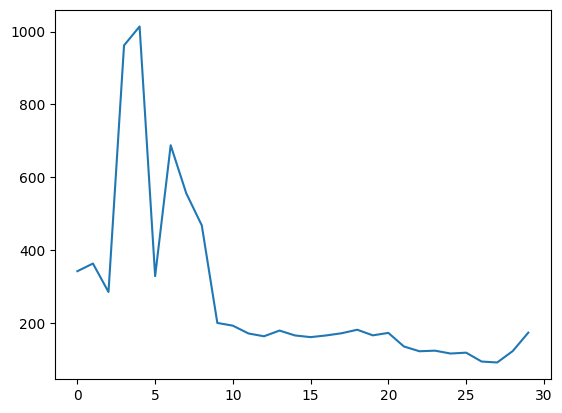

In [248]:
plt.plot(kl_divs[-30:])